### Converting the model to onnx

In [1]:
import dianna
import tensorflow as tf
import numpy as np
from pathlib import Path
%matplotlib inline
from matplotlib import pyplot as plt

2022-09-07 09:55:23.637234: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-07 09:55:23.637268: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
loaded_model = tf.keras.models.load_model('test_2018/pre-trained')

In [11]:
savedmodel_dir = 'test_2018/pre-trained'

In [12]:
onnx_savedmodel = 'test_2018/pre-trained.onnx'

In [13]:
!python3 -m tf2onnx.convert --saved-model {savedmodel_dir} --output {onnx_savedmodel} --signature_def serving_default --tag serve

2022-09-07 10:16:55.604079: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-07 10:16:55.604117: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-09-07 10:16:57.245172: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-07 10:16:57.245206: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-07 10:16:57.245246: 

### Saving inputs and targets to test

In [31]:
# scratchdir = Path('/scratch/lpalma/')
# experiment_name = 'trial2_ensmean'
# test_inputs = np.load(scratchdir / f'{experiment_name}.testing_inputs.npy')
# test_target = np.load(scratchdir / f'{experiment_name}.testing_terciles.npy')

# np.save('test_2018/test15_inputs', test_inputs[15])
# np.save('test_2018/test15_target', test_target[15])

### DIANNA

In [43]:
train_inputs = np.load('test_2018/train0_inputs.npy')
train_target = np.load('test_2018/train0_target.npy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


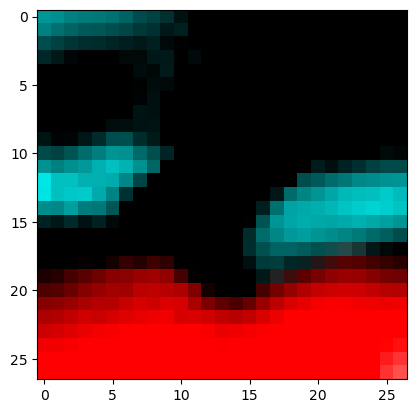

In [44]:
plt.imshow(train_inputs)

In [47]:
axs

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fac4fcefd90>,
      dtype=object)

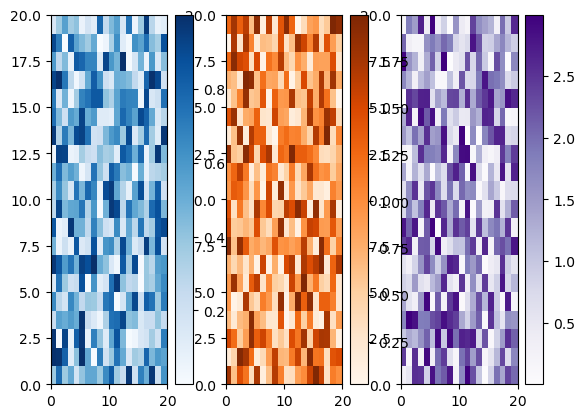

In [52]:
fig, axs = plt.subplots(1, 3)

for col in range(3):
    ax = axs[col]
    pcm = ax.pcolormesh(np.random.random((20, 20)) * (col + 1),
                        cmap=cmaps[col])
    fig.colorbar(pcm, ax=ax)
plt.show()

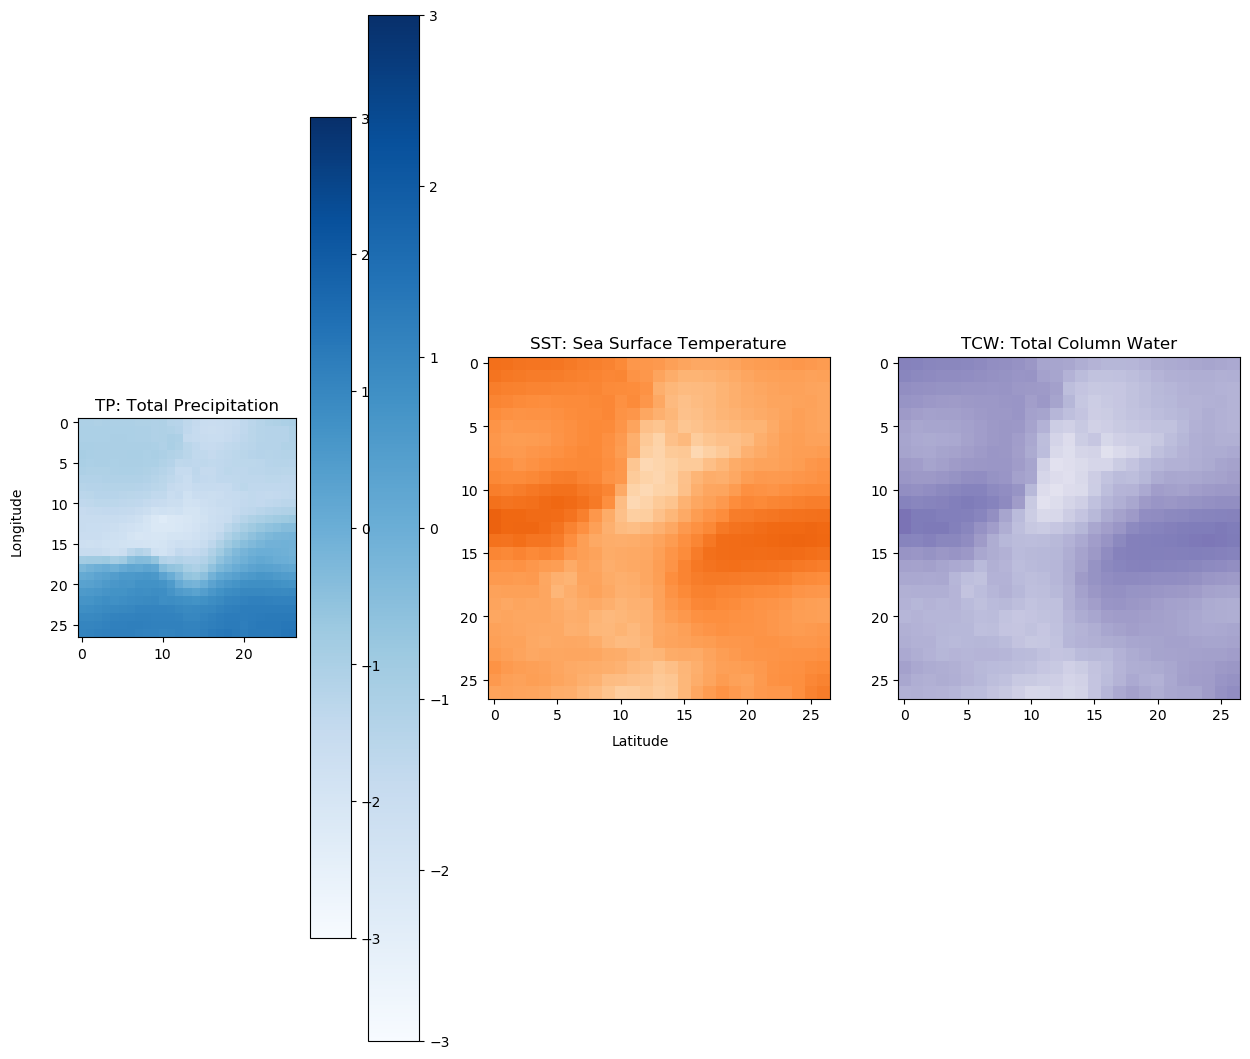

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
cmaps = ['Blues', 'Oranges', 'Purples']

fig.text(0.5, 0.35, 'Latitude', ha='center')
fig.text(0.08, 0.5, 'Longitude', va='center', rotation='vertical')

#fig.suptitle('Vertically stacked subplots')
pcm = ax1.imshow(train_inputs[:,:,0], cmap='Blues', vmin = -3, vmax = 3)
fig.colorbar(pcm, ax=ax1)
ax1.title.set_text('TP: Total Precipitation')

fig.colorbar(pcm, ax=ax1)

ax2.imshow(train_inputs[:,:,1], cmap='Oranges', vmin = -3, vmax = 3)
ax2.title.set_text('SST: Sea Surface Temperature')

ax3.imshow(train_inputs[:,:,2], cmap='Purples', vmin = -3, vmax = 3)
ax3.title.set_text('TCW: Total Column Water')